In [2]:
import pickle

In [10]:
with open('results/finetune_24_2.pkl', 'rb') as f:
    results = pickle.load(f)

results

print('number of warnings:', results['warnings'][1])
warnings = results['warnings'][0]
with open('warnings_24_2.txt', 'w', encoding='utf-8') as f:
    f.write(str(warnings))

number of warnings: 1


AttributeError: module 'matplotlib.pyplot' has no attribute 'label'

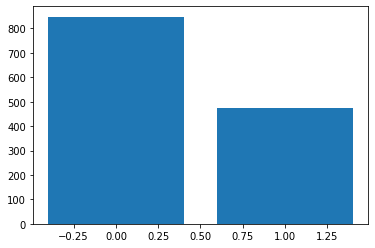

In [11]:
agg_score_bin = pd.read_csv('agg_score_bin.csv')
agg_score_bin = agg_score_bin.dropna()
scores_counter = Counter(agg_score_bin['score'])
scores_counter
plt.bar(scores_counter.keys(), scores_counter.values(), label= [0, 1])
plt.show()

In [2]:
df = pd.read_csv('kns_csv_files/kns_committee.csv')
df = df[df['KnessetNum'] >= 25]
df = df[df['CategoryID'].isin([MONEY_COM_CATEGORY_ID, DEFENSE_COM_CATEGORY_ID, LAW_ORDER_COM_CATEGORY_ID, MESADERET_COM_CATEGORY_ID, KNESSET_COM_CATEGORY_ID])]
commitee_ids = df['CommitteeID'].to_list()

In [3]:
def get_meeting_protocol_text(text_path):
    # Define the URL to fetch
    base_url = 'https://production.oknesset.org/pipelines/data/committees/meeting_protocols_text/'
    # Send GET request to the URL
    response = requests.get(base_url + text_path)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        response.encoding = 'utf-8'
        # Retrieve the content of the file
        return response.text
    else:
        raise ValueError(f"Failed to retrieve content. Status code: {response.status_code}")


In [4]:
com_session_df = pd.read_csv('kns_csv_files/kns_committeesession.csv')
com_session_df = com_session_df[com_session_df['CommitteeID'].isin(commitee_ids)]

com_session_df.dropna(subset=['text_parsed_filename'], inplace=True)
text_paths = com_session_df['text_parsed_filename'].to_list()
texts = [get_meeting_protocol_text(path) for path in text_paths]
agg_scores = [rate_aggressiveness(text) for text in texts]



NameError: name 'rate_aggressiveness' is not defined

In [ ]:
knesset_members_df = pd.read_csv('kns_csv_files/kns_person.csv')
first_names, last_names = knesset_members_df['FirstName'].to_list(), knesset_members_df['LastName'].to_list()
knesset_members = [' '.join([first_name, last_name]) for first_name, last_name in zip(first_names, last_names)]

warnings = {mem: [0, 0, 0] for mem in knesset_members}

# handle members with a middle name or a nickname
new_first_names, new_last_names = [], []

for fn, ln in zip(first_names, last_names):
    names = re.findall('\w+', fn)
    
    for name in names:
        warnings[name + ' ' + ln] = warnings[fn + ' ' + ln]
        new_first_names.append(name)
        new_last_names.append(ln)

# update first and last names
first_names = new_first_names
last_names = new_last_names

knesset_members = [' '.join([first_name, last_name]) for first_name, last_name in zip(first_names, last_names)]

In [ ]:
def get_meeting_warnings(text, warnings, knesset_members) -> None:
    """
    Return warnings from the meeting protocol text.

    Parameters
    ----------
    text : str
        Meeting protocol text.

    warnings: Dict[str, List[int]]
        Number of warnings for each Knesset member.

    knesset_members: List[str]
        List of Knesset members.
    """

    # find all warnings
    matches = re.findall(WARNING_REGEX, text, flags=re.MULTILINE)
    print(len(matches))
    for i, match in enumerate(matches):
        print(f'match #{i}:')
        print(match)
        sentences = match.split('\n')
        first_sentence, last_sentence = sentences[0], sentences[-1]
        for kns_member in knesset_members:
            if kns_member in first_sentence:
                word2idx = {'ראש': 0, 'שני': 1, 'שליש': 2}
                for word, idx in word2idx.items():
                    if word in last_sentence:
                        warnings[kns_member][idx] += 1
                        break
    
    

In [51]:
def filter_protocol_sentences(text: str) -> str:
    ind = re.search("<< יור >>", text)
    txt2 = text[ind.span()[0]:]
    txt2 = re.sub("<<.*","", txt2)
    txt2 = re.sub(">>.*","", txt2)
    txt2 = re.sub("-", " ", txt2)
    txt2 = re.sub("\n\s+","\n", txt2)
    txt2 = re.sub(" +"," ", txt2)
    return txt2

In [54]:
with open('protocols/2159679.txt', 'r', encoding='utf-8') as f:
    text = f.read()
filtered_text = filter_protocol_sentences(text)
with open('filtered_protocols/2159679.txt', 'w', encoding='utf-8') as f:
    f.write(filtered_text)

## AlephBert Transfer Learning

In [9]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [40]:
alephbert_tokenizer = AutoTokenizer.from_pretrained('onlplab/alephbert-base')
alephbert = AutoModelForSequenceClassification.from_pretrained('onlplab/alephbert-base', num_labels=2)

# Freeze the weights of the model
for param in list(alephbert.parameters())[:-1]:
    param.requires_grad = False

Some weights of the model checkpoint at onlplab/alephbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base

In [30]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        return text, label
    
    def __len__(self):
        return len(self.texts)

In [31]:
from sklearn.model_selection import train_test_split
agg_scores_df = pd.read_csv('agg_score_bin.csv')
agg_scores_df.dropna(inplace=True, ignore_index=True)

In [32]:
train_set, test_set = train_test_split(agg_scores_df, test_size=0.2)

# Reset the index of each DataFrame
train_set.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True, inplace=True)

agg_train = Dataset(train_set['text'], train_set['score'])
agg_test = Dataset(test_set['text'], test_set['score'])

train_dataloader = torch.utils.data.DataLoader(agg_train, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(agg_test, batch_size=16, shuffle=False)

In [42]:
from tqdm import tqdm

In [48]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alephbert.to(device)

# Set optimizer and loss function
optimizer = torch.optim.Adam(alephbert.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

# Train model
alephbert.train()
for epoch in range(5):
    print('epoch', epoch)
    for texts, scores in tqdm(train_dataloader):
        optimizer.zero_grad()
        scores = scores.long().to(device)
        inputs = alephbert_tokenizer(texts, padding=True, truncation=True, return_tensors='pt').to(device)
        outputs = alephbert(**inputs, return_dict=False)[0]

        loss = criterion(outputs, scores)
        loss.backward()
        optimizer.step()

    


  0%|          | 0/23 [00:00<?, ?it/s]

epoch 0


  0%|          | 0/23 [00:00<?, ?it/s]

epoch 1


  0%|          | 0/23 [00:00<?, ?it/s]

epoch 2


  0%|          | 0/23 [00:00<?, ?it/s]

epoch 3


  0%|          | 0/23 [00:00<?, ?it/s]

epoch 4


  0%|          | 0/23 [00:00<?, ?it/s]

epoch 5


  0%|          | 0/23 [00:00<?, ?it/s]

epoch 6


  0%|          | 0/23 [00:00<?, ?it/s]

epoch 7


  0%|          | 0/23 [00:00<?, ?it/s]

epoch 8


  0%|          | 0/23 [00:00<?, ?it/s]

epoch 9


  0%|          | 0/23 [00:00<?, ?it/s]

epoch 10


  0%|          | 0/23 [00:00<?, ?it/s]

epoch 11


  0%|          | 0/23 [00:00<?, ?it/s]

epoch 12


  0%|          | 0/23 [00:00<?, ?it/s]

epoch 13


  0%|          | 0/23 [00:00<?, ?it/s]

epoch 14


  0%|          | 0/23 [00:00<?, ?it/s]

epoch 15


  0%|          | 0/23 [00:00<?, ?it/s]

epoch 16


  0%|          | 0/23 [00:00<?, ?it/s]

epoch 17


  0%|          | 0/23 [00:00<?, ?it/s]

epoch 18


  0%|          | 0/23 [00:00<?, ?it/s]

epoch 19


  0%|          | 0/23 [00:00<?, ?it/s]

epoch 20


  0%|          | 0/23 [00:00<?, ?it/s]

epoch 21


  0%|          | 0/23 [00:00<?, ?it/s]

epoch 22


  0%|          | 0/23 [00:00<?, ?it/s]

epoch 23


  0%|          | 0/23 [00:00<?, ?it/s]

epoch 24


100%|██████████| 23/23 [01:06<00:00,  2.87s/it]


In [51]:
torch.save(alephbert, 'model.pt')

In [49]:
# Evaluate model
alephbert.eval()
preds_df = pd.DataFrame(columns=['predictions', 'scores'])

total = 0
correct = 0

with torch.no_grad():
    for texts, scores in test_dataloader:
        inputs = alephbert_tokenizer(texts, padding=True, truncation=True, return_tensors='pt').to(device)
        scores = scores.to(device)

        outputs = alephbert(**inputs, return_dict=False)[0]
        _, predicted = torch.max(outputs.data, 1)
        total += scores.size(0)
        correct += (predicted == scores).sum().item()

        # outputs = outputs.reshape((16,))

        # agg score is between 1 to 7
        # outputs = np.round(outputs)
        
        d = {'predictions': [o.item() for o in predicted], 'scores': [s.item() for s in scores]}
        df = pd.DataFrame.from_dict(d)
        preds_df = pd.concat([preds_df, df], ignore_index=True, copy=False)

print('total accuracy on test set:', correct/total)

total accuracy on test set: 0.5760869565217391


In [47]:
preds_df.describe()

,predictions,scores
count,92,92
unique,2,2
top,0,0
freq,81,49
